# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.

Алгоритм действий:

1. Загрузим и подготовим данные.
2. Обучим разные модели. 
3. Выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#KNN" data-toc-modified-id="KNN-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>KNN</a></span></li><li><span><a href="#BERT" data-toc-modified-id="BERT-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>BERT</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from pymystem3 import Mystem
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 

import nltk
from nltk.corpus import stopwords

import re
import warnings

RS=1234
warnings.filterwarnings('ignore')
sns.set_style()

In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')

Рассмотрим первые пять строк в таблице:

In [3]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Изучим основную информацию:

In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 80.1 MB


Проверим данные на пропуски:

In [5]:
df.isna().sum()

text     0
toxic    0
dtype: int64

Проверим данные на дубликаты:

In [6]:
df.duplicated().sum()

0

Оптимизируем тип данных:

In [7]:
df.toxic = df.toxic.astype('uint8')

Изучим баланс классов:

<AxesSubplot:>

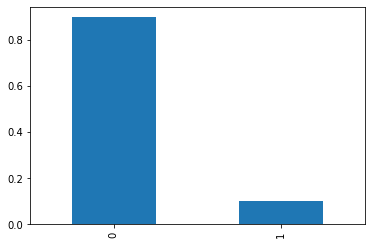

In [8]:
df.toxic.value_counts(normalize=True).plot(kind='bar')

In [9]:
len(df.toxic[df.toxic==0]) / len(df.toxic[df.toxic==1])

8.834884437596301

Создадим функцию, которая проводит операцию лемматизации и фильтрации текста:

In [10]:
m = WordNetLemmatizer()

In [11]:
def text_transform(text):
    lemma = re.sub(r'[^a-zA-Z]', ' ', m.lemmatize(text, wordnet.VERB))
    return ' '.join(lemma.split())

Создадим новый столбец `lem_text`, содержащий обработанный текст

In [12]:
df['lem_text'] = df['text'].apply(text_transform)

Выделим целевую переменную и признак:

In [13]:
X, y = df['lem_text'], df['toxic']

Разделим данные на набор для обучения и тестирования:

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RS)

In [16]:
stopwords = set(stopwords.words('english'))
tf_idf = TfidfVectorizer(stop_words=stopwords, )

In [23]:
X_train_tf = tf_idf.fit_transform(X_train)
X_test_tf = tf_idf.transform(X_test)

### Вывод

Данные загружены и изучены. Проведена проверка на дубликаты и пропуски. В данных наблюдается сильный дисбаланс классов в целевой переменной. Подготовлены данны для обучения и тестирования моделей.

## Обучение

### Логистическая регрессия

Создадим модель логистической регрессии с балансировкой классов:

In [18]:
pipe = Pipeline([('tf_idf', TfidfVectorizer()), ('clf', LogisticRegression(class_weight='balanced'))])

Проверка на кросс-валидации:

In [19]:
cross_val_score(pipe, X_train, y_train).mean()

0.940190832078371

Обучим модель для дальнейшего тестирования:

In [20]:
LR = LogisticRegression(class_weight='balanced')

In [25]:
LR.fit(X_train_tf, y_train)

LogisticRegression(class_weight='balanced')

### CatBoost

Создадим модель градиентного бустинга:

In [26]:
cat = CatBoostClassifier(auto_class_weights='Balanced', eval_metric='F1')

Определим диапазон гиперпараметров, значения для которых будут подобраны с использованием поиска по сетке:

In [27]:
params = {'iterations': range(100, 501 , 100),
          'depth': range(5, 8),
          'learning_rate': np.arange(0.1, 0.31, 0.1),
          'l2_leaf_reg': np.arange(3, 8, 2),
          'verbose': [10],
          'early_stopping_rounds' : [20]
         }

Для ускорения вычислений ограничим количество признаков:

In [29]:
X_train_cb = X_train_tf[:10000]
y_train_cb = y_train[:10000]

X_test_cb = X_test_tf[:5000]
y_test_cb = y_test[:5000]

In [30]:
#grid = cat.grid_search(params, X_train_cb, y_train_cb, cv=3)
#best_params = grid['params']

In [31]:
best_params = {'depth': 5,
               'od_wait': 20,
               'verbose': 10,
               'l2_leaf_reg': 7,
               'iterations': 200,
               'learning_rate': 0.1}

Обучим модель на наилучших параметрах:

In [32]:
cat = CatBoostClassifier(**best_params)

In [33]:
cat.fit(X_train_cb, y_train_cb)

0:	learn: 0.6002340	total: 354ms	remaining: 1m 10s
10:	learn: 0.2857314	total: 3.45s	remaining: 59.4s
20:	learn: 0.2372061	total: 6.58s	remaining: 56.1s
30:	learn: 0.2184250	total: 9.75s	remaining: 53.2s
40:	learn: 0.2085832	total: 12.9s	remaining: 50.2s
50:	learn: 0.2001617	total: 16.1s	remaining: 47.1s
60:	learn: 0.1945158	total: 19.3s	remaining: 43.9s
70:	learn: 0.1896907	total: 22.4s	remaining: 40.8s
80:	learn: 0.1849357	total: 25.5s	remaining: 37.5s
90:	learn: 0.1812287	total: 28.7s	remaining: 34.3s
100:	learn: 0.1770683	total: 31.7s	remaining: 31s
110:	learn: 0.1733286	total: 34.7s	remaining: 27.8s
120:	learn: 0.1685252	total: 37.8s	remaining: 24.7s
130:	learn: 0.1662809	total: 41s	remaining: 21.6s
140:	learn: 0.1632551	total: 44.3s	remaining: 18.5s
150:	learn: 0.1600732	total: 47.4s	remaining: 15.4s
160:	learn: 0.1575982	total: 50.3s	remaining: 12.2s
170:	learn: 0.1559889	total: 53.2s	remaining: 9.02s
180:	learn: 0.1542113	total: 56.1s	remaining: 5.88s
190:	learn: 0.1511387	tota

### KNN

Создадим модель, основанная на методе ближайших соседей:

In [35]:
pipe = Pipeline([('tf_idf', TfidfVectorizer()), ('clf', KNeighborsClassifier(n_neighbors=10))])

Проверим модель на кросс - валидации:

In [36]:
cross_val_score(pipe, X_train, y_train, scoring='f1', cv=5).mean()

0.4126660450832678

In [38]:
kNN = KNeighborsClassifier(n_neighbors=10)

Обучим модель для дальнейшего тестирования:

In [40]:
kNN.fit(X_train_tf, y_train)

KNeighborsClassifier(n_neighbors=10)

### Вывод

Построены следующие модели машинного обучения:
* LogisticRegression
* CatBoost
* kNNClassifier

Для модели градиентного бустинга выполнен подбор гиперпараметров. Наиболее точная модель по результатам кросс - валидации - **Логистическая регрессия**

## Тестирование

Предсказание для модели Логистической регрессии:

In [42]:
predictions = LR.predict(X_test_tf)
f1_score(y_test, predictions)

0.7548315847598012

Предсказание для модели Градиентного бустинга:

In [43]:
predictions = cat.predict(X_test_tf)
f1_score(y_test, predictions)

0.6093251011283799

Предсказание для модели метода ближайших соседей:

In [44]:
predictions = kNN.predict(X_test_tf)
f1_score(y_test, predictions)

0.18434486670448097

### Вывод

Проведено тестирование на отложенной выборке: результаты показывают, что также, как и при валидации, модель Логистической регрессии показала себя наилучшим образом

## Выводы

Таким образом, были подготовленны несколько моделей машинного обучения для предсказания тональности текста. Для подготовки признаков была использована мера **TF-IDF**. По результатам тестирования наиболее точной показала себя модель **Логистической регрессии**